# Overview

Useful Resources:
- https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-image-processing.html
- https://middlebury-csci-0451.github.io/CSCI-0451/lecture-notes/introducing-dimensionality-reduction.html
- https://towardsdatascience.com/svd-8c2f72e264f

Unlike supervised learning, unsupervised learning tasks do not have targets. Rather, they focus on finding patterns within the data. 

Singular Value Decomposition (SVD) is a matrix factorization method that can allow us to do dimensionality reduction, a form of unsupervised learning that focuses on reducing the number of features in our data while preserving its essence for more efficient analysis.

The decomposition relies on calculating "singular values" that help us estimate the size of the original matrix with less info as is explained in the article(https://towardsdatascience.com/svd-8c2f72e264f):

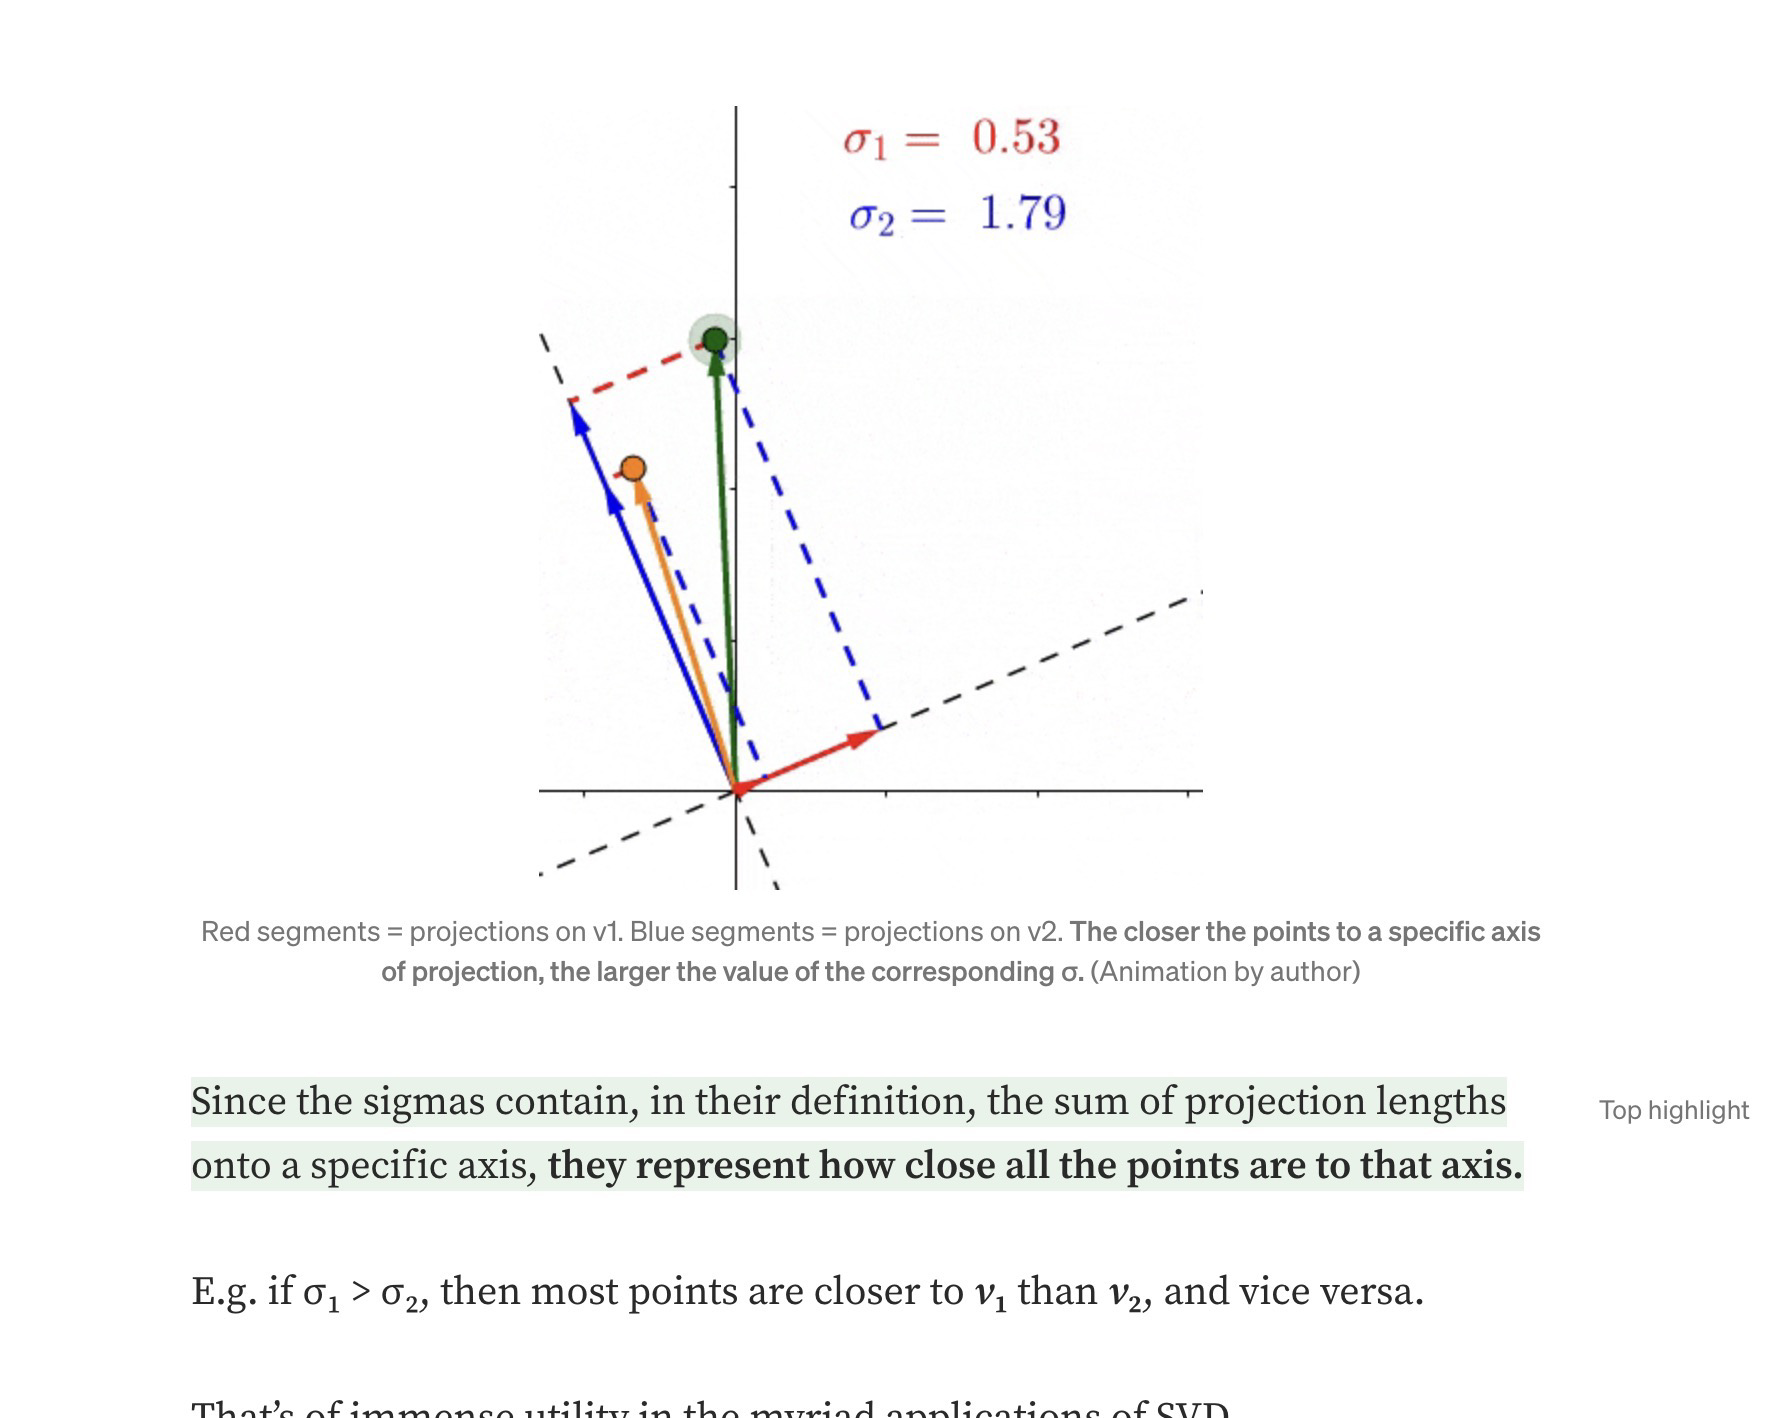

# Experiment

Overall goal: 
- Decompose an image of our choice using SVD. 
- Experiment with different # k of singular value components to be used in the decomposition
- Develop compression factor parameter that if enabled will choose the # k of singular value components to be used in the decomposition.

Useful Resource: https://medium.com/@thusharabandara/measure-the-compression-performance-of-an-image-compression-algorithm-ea68c1839ec6

### Fetching Image + Turning it to Black & White 

In [396]:
import PIL
import urllib

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

In [387]:
url = "https://tinypng.com/images/social/website.jpg"
img = read_image(url)

[Text(0.5, 1.0, 'greyscale')]

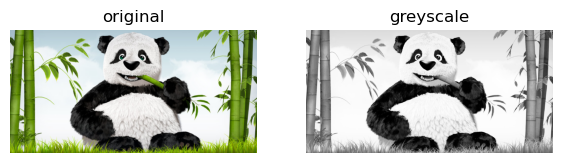

In [388]:
fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

grey_img = to_greyscale(img)


axarr[0].imshow(img)
axarr[0].axis("off")
axarr[0].set(title = "original")

axarr[1].imshow(grey_img, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = "greyscale")

### Decomposition + Analysis
In the following function, we will pass our black and white image, decompose it and examine results. 

In [494]:
def svd_reconstruct(image, k, cf=None):
    
    A = image #our image is m*n matrix
    U, sigma, V = np.linalg.svd(A)#decompose with built in numpy svd
    
    m,n = image.shape[0], image.shape[1]
    og_img_px = m*n
    print(f"The # of pixels needed to store original image is {og_img_px}")
    
    # create the D matrix in the SVD
    D = np.zeros_like(A,dtype=float) # matrix of zeros of same shape as A
    D[:min(A.shape),:min(A.shape)] = np.diag(sigma) # singular values on the main diagonal

    #Calculating Compression Factor
    #compression factor is orinal/compressed 
    #original = A; compressed = A_
    #A = m*n
    #A_ = k*m + k(diagonals matrix is 0'd out so use k instead of k*k) + n*k
    #cf = A/A_
    #cf = m*n/k*m + k + n*k
    #cf = m*n/k(m+1+n)
    #cf(m+1+n) = m*n/k
    #k*cf(m+1+n)= m*n
    #k = m*n/cf(m+1+n)
    
    choose_k = 0
    if(cf != None):
        choose_k = int(((m*n) / (cf * (m+1+n))))
    
    if (choose_k > 0):
        
        U_ = U[:,:choose_k]
        D_ = D[:choose_k, :choose_k]
        V_ = V[:choose_k, :]
    
        A_ = U_ @ D_ @ V_
        new_img_px = choose_k*m + choose_k + n*choose_k
        print(f"The # of pixels needed to store compressed image is {new_img_px}\n")
        
        return A_
    
    U_ = U[:,:k]
    D_ = D[:k, :k]
    V_ = V[:k, :]
    
    A_ = U_ @ D_ @ V_
    
    new_img_px = k*m + k + n*k
    print(f"The # of pixels needed to store compressed image is {new_img_px}\n")
     
    return A_

In [495]:
#compare original size to new size
svd_reconstruct(grey_img,25)
svd_reconstruct(grey_img,8)

svd_reconstruct(grey_img,8, cf = 70)
svd_reconstruct(grey_img,8, cf = 5)

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 38275

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 12248

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 6124

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 102577



array([[-166.58691639, -166.83674027, -171.06369029, ...,  -74.47347323,
        -102.7494874 , -129.49640076],
       [-171.05893064, -171.90815828, -177.41906167, ...,  -56.2651186 ,
         -92.05222797, -121.56358122],
       [-178.59615127, -178.46205866, -183.14545662, ...,  -51.42475947,
         -90.07937304, -121.04338246],
       ...,
       [ -89.64106677,  -82.82397266,  -87.57796423, ..., -105.63327921,
        -130.67409141, -140.58034411],
       [ -81.86134331,  -74.64474276,  -79.75364623, ..., -105.92576626,
        -123.65154946, -127.40840671],
       [ -80.18976813,  -72.07005171,  -77.28038033, ..., -101.24308323,
        -118.08228953, -119.9544055 ]])

#### Take-Aways: 
- The higher the k, the less compression is done. 
- The higher the compression factor, the smaller the k, so more compression is done.

### Effect of Decomposition
In the following function, we will use our svd_reconstruct() function to perform an experiment in which we iteratively increase the # k of singular value components to be used in the decomposition and see how it affects image quality and storage.

In [496]:
def svd_experiment(image):
    
    #arrays to store compressed images, scores
    img_array = []
    score_calc = []

    #Calculating Compression Rate
    #compression rate is compressed/original 
    m,n = image.shape[0], image.shape[1]
    original_image_pixels = m * n 
    
    for i in range(5,56,10): #i is the k
        img_array.append(svd_reconstruct(image, k = i))
        
        #compression ratio
        reduced_image_pixels = (m * i) + i + (i*n)
        score_calc.append((reduced_image_pixels / original_image_pixels*100))
    
    fig, axarr = plt.subplots(2, 3, figsize=(15,5), sharex = False, sharey = False)
    
    #indices
    img_index = 0
    component_index = 5
    
    #loop through subplots
    axarr = axarr.flatten()
    for a in axarr:
        a.imshow(img_array[img_index], interpolation='none', cmap = "Greys")
        a.axis("off")
        a.set(title = str(component_index) + " components, " + "storage: " + str(round((score_calc[img_index]), 4)) + "%")
        component_index = component_index + 10
        img_index = img_index + 1

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 7655

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 22965

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 38275

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 53585

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 68895

The # of pixels needed to store original image is 520200
The # of pixels needed to store compressed image is 84205



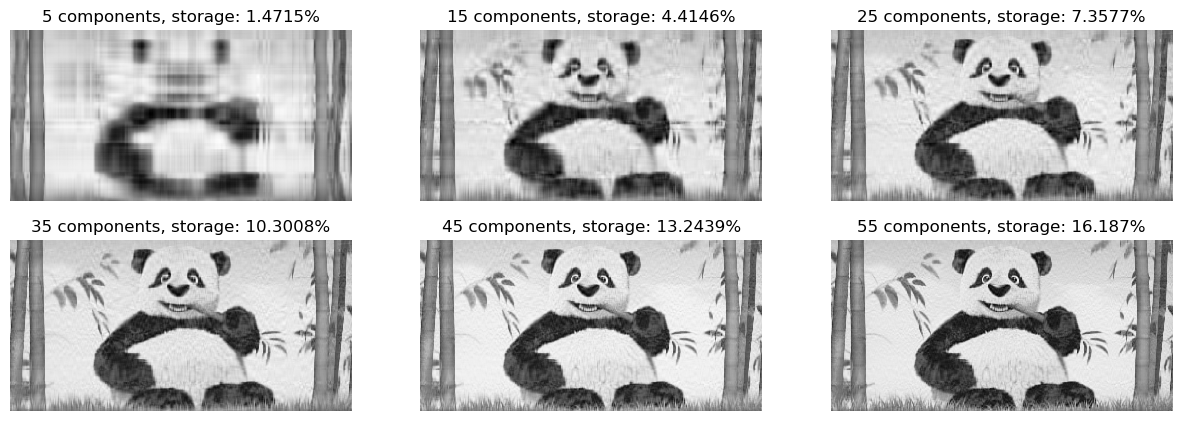

In [497]:
svd_experiment(grey_img)

#### Take-Away: With only about 16% of the pixels available from original matrix being used to display the image, it is almost undistinguishable from the original image, which shows the power of dimensionality reduction.